In [1]:
%cd /global/u2/z/zeyuanhu/nvidia_codes/Climsim_private/
from climsim_utils.data_utils import *

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/global/u2/z/zeyuanhu/nvidia_codes/Climsim_private


2025-02-07 20:49:12.910758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-07 20:49:12.910856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-07 20:49:12.973300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 20:49:13.121156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from dataclasses import dataclass
import modulus
from modulus.metrics.general.mse import mse
from modulus.utils import StaticCaptureTraining, StaticCaptureEvaluateNoGrad
from omegaconf import DictConfig
from modulus.launch.logging import (
    PythonLogger,
    LaunchLogger,
    initialize_wandb,
    RankZeroLoggingWrapper,
)

In [3]:
%cd /global/u2/z/zeyuanhu/nvidia_codes/Climsim_private/Hu_models/Unet_v2rh_mc/training
from climsim_unet import ClimsimUnet
import climsim_unet as climsim_unet

/global/u2/z/zeyuanhu/nvidia_codes/Climsim_private/Hu_models/Unet_v2rh_mc/training


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
climsim_path = '/global/u2/z/zeyuanhu/nvidia_codes/Climsim_private/'
grid_path = climsim_path+'/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = climsim_path+'/preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean_v5_pervar.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max_v5_pervar.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min_v5_pervar.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale_std_lowerthred_v5.nc')
# del data
data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale,
                 qinput_log=False,
                 normalize=False)

lbd_qn = np.loadtxt(norm_path + 'inputs/qn_exp_lambda_large.txt', delimiter=',')

    
# set variables to V1 subset
data.set_to_v5_vars()

input_sub, input_div, out_scale = data.save_norm(write=False)

In [5]:
class NewModel(nn.Module):
    def __init__(self, original_model, input_sub, input_div, out_scale, lbd_qn):
        super(NewModel, self).__init__()
        self.original_model = original_model
        self.input_sub = torch.tensor(input_sub, dtype=torch.float32, device=torch.device("cuda"))
        self.input_div = torch.tensor(input_div, dtype=torch.float32, device=torch.device("cuda"))
        self.out_scale = torch.tensor(out_scale, dtype=torch.float32, device=torch.device("cuda"))
        self.lbd_qn = torch.tensor(lbd_qn, dtype=torch.float32, device=torch.device("cuda"))

    def to(self, device):
        """Ensure all tensors are moved to the correct device"""
        self.input_sub = self.input_sub.to(device)
        self.input_div = self.input_div.to(device)
        self.out_scale = self.out_scale.to(device)
        self.lbd_qn = self.lbd_qn.to(device)
        return super().to(device)
    
    def apply_temperature_rules(self, T):
        # Create an output tensor, initialized to zero
        output = torch.zeros_like(T)

        # Apply the linear transition within the range 253.16 to 273.16
        mask = (T >= 253.16) & (T <= 273.16)
        output[mask] = (T[mask] - 253.16) / 20.0  # 20.0 is the range (273.16 - 253.16)

        # Values where T > 273.16 set to 1
        output[T > 273.16] = 1

        # Values where T < 253.16 are already set to 0 by the initialization
        return output

    def preprocessing(self, x):
        
        # convert v4 input array to v5 input array:
        xout = x
        xout_new = torch.zeros((xout.shape[0], 1405), dtype=xout.dtype, device=x.device)
        xout_new[:,0:120] = xout[:,0:120]
        xout_new[:,120:180] = xout[:,120:180] + xout[:,180:240]
        xout_new[:,180:240] = self.apply_temperature_rules(xout[:,0:60])
        xout_new[:,240:840] = xout[:,240:840] #60*14
        xout_new[:,840:900] = xout[:,840:900]+ xout[:,900:960] #dqc+dqi
        xout_new[:,900:1080] = xout[:,960:1140]
        xout_new[:,1080:1140] = xout[:,1140:1200]+ xout[:,1200:1260]
        xout_new[:,1140:1405] = xout[:,1260:1525]
        x = xout_new
        
        #do input normalization
        x[:,120:180] = 1 - torch.exp(-x[:,120:180] * self.lbd_qn.to(x.device))
        x= (x - self.input_sub.to(x.device)) / self.input_div.to(x.device)
        x = torch.where(torch.isnan(x), torch.tensor(0.0, device=x.device), x)
        x = torch.where(torch.isinf(x), torch.tensor(0.0, device=x.device), x)
        
        #prune top 15 levels in qn input
        x[:,120:120+15] = 0
        #clip rh input
        x[:, 60:120] = torch.clamp(x[:, 60:120], 0, 1.2)

        # convert v5 input to v2rh_mc input
        xout_new2 = torch.zeros((xout.shape[0], 557), dtype=xout.dtype, device=x.device)
        xout_new2[:,0:360] = x[:,0:360]
        xout_new2[:,360:557] = x[:,1200:1397]
        # xout_new2[:,540:557] = x[:,1380:1397]
        x = xout_new2
        return x

    def postprocessing(self, x):
        x[:,60:75] = 0
        x[:,120:135] = 0
        x[:,180:195] = 0
        x[:,240:255] = 0
        x = x/self.out_scale
        return x

    def forward(self, x):
        print(f"Model forward pass running on device: {x.device}")
        # Print the number of available CUDA devices
        num_gpus = torch.cuda.device_count()
        print(f"Number of available CUDA devices: {num_gpus}")
        t_before = x[:,0:60].clone()
        qc_before = x[:,120:180].clone()
        qi_before = x[:,180:240].clone()
        qn_before = qc_before + qi_before
        
        x = self.preprocessing(x)
        x = self.original_model(x)
        x = self.postprocessing(x)
        
        t_new = t_before + x[:,0:60]*1200.
        qn_new = qn_before + x[:,120:180]*1200.
        liq_frac = self.apply_temperature_rules(t_new)
        qc_new = liq_frac*qn_new
        qi_new = (1-liq_frac)*qn_new
        xout = torch.zeros((x.shape[0],368), device=x.device)
        xout[:,0:120] = x[:,0:120]
        xout[:,240:] = x[:,180:]
        xout[:,120:180] = (qc_new - qc_before)/1200.
        xout[:,180:240] = (qi_new - qi_before)/1200.
        return xout

In [6]:
device = torch.device("cuda")
f_torch_model = '/pscratch/sd/z/zeyuanhu/hugging/E3SM-MMF_ne4/saved_models/v2rh_mc_fix_huber/model.mdlus'
model_inf = modulus.Module.from_checkpoint(f_torch_model).to(device)
new_model = NewModel(model_inf, input_sub, input_div, out_scale, lbd_qn).to(device)
NewModel.device = "cuda"
device = torch.device("cuda")
scripted_model = torch.jit.script(new_model)
scripted_model = scripted_model.eval()
save_file_torch = os.path.join('/pscratch/sd/z/zeyuanhu/hugging/E3SM-MMF_ne4/saved_models_wrapper/', 'v2rh_mc_fix_huber_cuda.pt')
scripted_model.save(save_file_torch)

In [7]:
device = torch.device("cuda")
f_torch_model = '/pscratch/sd/z/zeyuanhu/hugging/E3SM-MMF_ne4/saved_models/v2rh_mc_unet_fix_mae/model.mdlus'
model_inf = modulus.Module.from_checkpoint(f_torch_model).to(device)
new_model = NewModel(model_inf, input_sub, input_div, out_scale, lbd_qn).to(device)
NewModel.device = "cuda"
device = torch.device("cuda")
scripted_model = torch.jit.script(new_model)
scripted_model = scripted_model.eval()
save_file_torch = os.path.join('/pscratch/sd/z/zeyuanhu/hugging/E3SM-MMF_ne4/saved_models_wrapper/', 'v2rh_mc_unet_fix_mae_cuda.pt')
scripted_model.save(save_file_torch)

# do inference on GPU

In [8]:
# Change this path to your own
data_path = '/pscratch/sd/z/zeyuanhu/hugging/E3SM-MMF_ne4/preprocessing/v4_testset/'

train_input_path = data_path + 'train_input.npy'
train_target_path = data_path + 'train_target.npy'
val_input_path = data_path + 'val_input.npy'
val_target_path = data_path + 'val_target.npy'

# data.input_train = data.load_npy_file(train_input_path)
# data.target_train = data.load_npy_file(train_target_path)
v4_input = np.load(val_input_path)
v4_target = np.load(val_target_path)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
X_input_tensor = torch.tensor(v4_input[0:3840,:], dtype=torch.float32).to(device)
scripted_model_read = torch.jit.load("/pscratch/sd/z/zeyuanhu/hugging/E3SM-MMF_ne4/saved_models_wrapper/v2rh_mc_fix_huber_cuda.pt", map_location=device)


In [10]:
with torch.no_grad():
    unet_pred_val = scripted_model_read(X_input_tensor[0:3840,:]).to('cpu').numpy()

Model forward pass running on device: cuda:0
Number of available CUDA devices: 1


In [12]:
truth_val = v4_target[:3840,:]
ss_res_mlp_orig = np.sum((truth_val - unet_pred_val) ** 2, axis=0)

# Calculate the denominator (total sum of squares)
ss_tot = np.sum((truth_val - np.mean(truth_val, axis=0)) ** 2, axis=0)

# Calculate R^2 for each feature for MLP
# r2_per_feature_unet_v4 = 1 - (ss_res_mlp_orig / ss_tot)
r2_per_feature_unet_decloud = 1 - (ss_res_mlp_orig / ss_tot)

/tmp/ipykernel_764262/2229946803.py:9: RuntimeWarning: divide by zero encountered in divide
  r2_per_feature_unet_decloud = 1 - (ss_res_mlp_orig / ss_tot)
/tmp/ipykernel_764262/2229946803.py:9: RuntimeWarning: invalid value encountered in divide
  r2_per_feature_unet_decloud = 1 - (ss_res_mlp_orig / ss_tot)


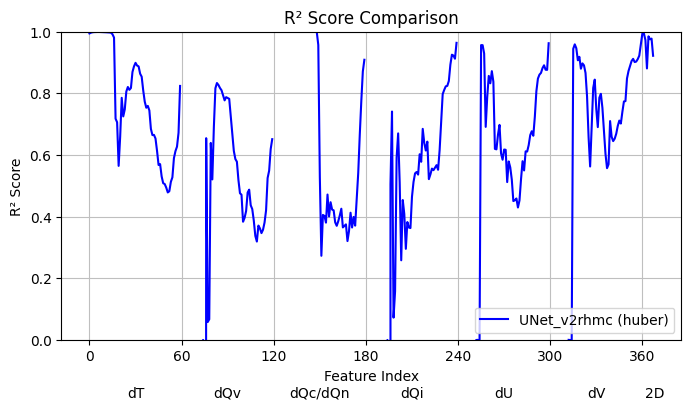

In [13]:
# Generate x-axis values (feature indices)
# r2_per_feature_unet_v4 = np.load('/global/u2/z/zeyuanhu/notebooks/r2_unet_v4_baseline_fulldata.npy')
# # r2_baseline_climsim = np.load('/global/u2/z/zeyuanhu/notebooks/r2_unet_baseline_kaggle.npy')
# r2_baseline_climsim = np.load('/global/u2/z/zeyuanhu/notebooks/james-plots/r2_final/r2-v2rh_unet_nonaggressive_cliprh_huber_rop2.npy')

features = np.arange(368)

r2_v2rhmc = r2_per_feature_unet_decloud.copy()
plt.figure(figsize=(8, 4))
# plt.plot(features, r2_per_feature_mlp, linestyle='-', color='cyan', label='MLP')
# plt.plot(features, r2_per_feature_unet_v3, linestyle='-', color='b', label='Unet_v3')
plt.plot(features, r2_v2rhmc, linestyle='-', color='b', label='UNet_v2rhmc (huber)')
# plt.plot(features, r2_per_feature_unet_v4, linestyle='-', color='orange', label='UNet_v4_full')
# plt.plot(features, r2_baseline_climsim, linestyle='-', color='red', label='UNet_v2 (huber in paper)')
plt.title('R² Score Comparison')
plt.xlabel('Feature Index')
plt.ylabel('R² Score')

# Set original x ticks and manually add labels for specific features
original_ticks = np.arange(0, r2_v2rhmc.size, 60)
plt.xticks(original_ticks)
feature_labels = ['dT', 'dQv', 'dQc/dQn', 'dQi', 'dU', 'dV', '2D']
for i, label in zip(original_ticks, feature_labels):
    plt.text(i+ 30 if label!='2D' else i+8, -0.15, label, ha='center', va='top')

plt.ylim(0,1)
plt.grid(True, which='both', axis='both', linestyle='-', color='0.75')
plt.legend() # Add legend
plt.show()
